In [1]:
from data_retriever import DataRetriever
from pre_processing import PreProcessing
from scalers.min_max import MinMax
from regressors.lstm_regressor import LSTMRegressor
from regressors.esn_regressor import ESNRegressor
import pandas as pd
from model_evaluator import ModelEvaluator
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dense, LSTM
from keras.models import Sequential
from config import Config
from statsmodels.tsa.stattools import adfuller

[*********************100%***********************]  7 of 7 completed
Learning to predict stock : ITUB3.SA_Close
Saving picture from results of prediction of predicted only :ITUB3.SA_Close , using model : ESN


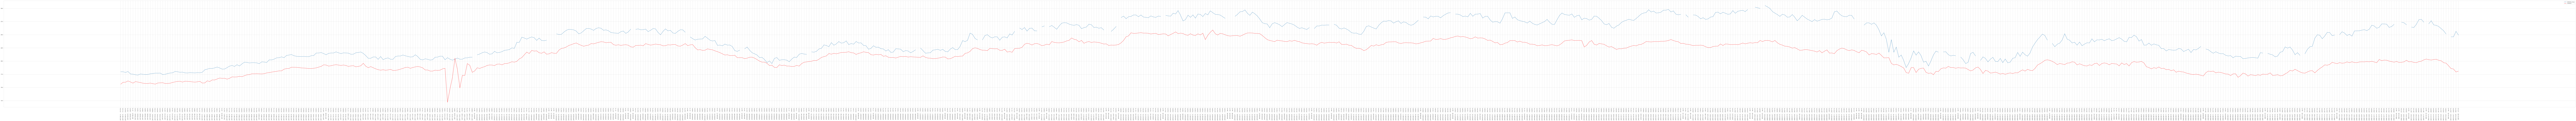

In [5]:
#Retrieving data from yahoo API
a = DataRetriever()
a.get_yahoo_stock_data()

#Defining which stocks will be predicted
#x_cols_ = [x for x in b.columns.difference(['Date']) if x[-5:] == 'Close']
predict_cols = ['ITUB3.SA_Close']

#Training a model for each stock to be predicted
for i in predict_cols:
    print('Learning to predict stock : ' + i)

    #Obtaining yahoo dataset
    dataset = a.get_stock_ds()
    
    #Setting up column to be predicted
    y_cols = i
    #Setting up column to be used as features
    x_cols = dataset.columns.difference(['Date'] + list(y_cols))
    
    #Preprocessing yahoo data
    pp = PreProcessing(dataset, MinMax)
    train, test = pp.pre_process()

    #Training model to preprocessed data
    #reg = LSTMRegressor(ds=train, xcols=x_cols, y_cols=y_cols, n_inputs=7, n_features=len(x_cols), epochs=50)
    reg = ESNRegressor(ds=train, xcols=x_cols, y_cols=y_cols, n_inputs=7, n_features=len(x_cols), epochs=50)
    reg.fit_generator()
    
    #Predicting data with trained model
    reg_pred = reg.predict_generator(test)
    
    #Adding predicted data to original dataset
    reg_pred = pp._scalers[y_cols].inverse_transform(reg_pred)
    pred = pd.DataFrame(reg_pred)
    pred.columns = ['Prediction']
    begin_idx  = len(dataset) - len(pred)
    finish_idx = len(dataset) - 1
    pred.index = list(range(begin_idx, finish_idx + 1))
    dataset = dataset.join(pred)

    #Evaluating model
    me = ModelEvaluator('ESN', dataset, 'Prediction', y_cols, 'Date')
    #me.plot_results(False, True)
    me.plot_results_predicted(False, True)